In [28]:
import os, re, sys, argparse, math, random, glob
import numpy as np
from enum import Enum
from itertools import chain
from network_topology import *
from matplotlib_helper import *
from common_util import *
from math import sqrt
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.ticker import *
from dataclasses import dataclass
from typing import List

In [29]:
def parse_fct(filename):
    # Example: '4936 (1048576B) 0.004762s'
    regex = re.compile(r'(\d+) \((\d+)B\) ([\d.e-]+)s')
    data = {}
    with open(filename) as f:
        for line in f:
            m = regex.match(line)
            if not m:
                raise ValueError('Cannot parse line "%s"' % line)
            flow_id = int(m.group(1))
            flow_size = int(m.group(2))
            flow_fct = float(m.group(3))
            if flow_id not in data:
                data[flow_id] = []
            data[flow_id].append((flow_size, flow_fct))
    return data

In [30]:
def parse_flowsize_from_log(filename):
    # Example: 'Flow ID 32717 (11212871B) starting at 0s'
    regex = re.compile(r'Flow ID (\d+) \((\d+)B\) starting at 0s')
    d_flowsize = {}
    with open(filename) as f:
        for line in f:
            if 'finished after' in line:
                break
            m = regex.match(line)
            if not m:
                continue
            flow_id = int(m.group(1))
            flow_size = int(m.group(2))
            if flow_id not in d_flowsize:
                d_flowsize[flow_id] = flow_size
    return d_flowsize

In [31]:
def plot_cdf_tuple_array(value_percentile_array, label, include_count = False, index=0, color=None):
    x = [t[0] for t in value_percentile_array]
    y = [t[1] for t in value_percentile_array]
    if include_count:
        label += ' (%d)' % len(value_percentile_array)
    if color is None:
        color = get_next_color()
    plt.plot(x, y, label=label, color=color, linestyle=get_linestyle(index))

In [32]:
def plot_pdf_from_cdf_tuple_array(value_percentile_array, label, include_count = False, index=0, color=None):
    x = [t[0] for t in value_percentile_array]
    y = [t[1] for t in value_percentile_array]
    for i in range(len(y) - 1, 0, -1):
        y[i] -= y[i - 1]
    if include_count:
        label += ' (%d)' % len(value_percentile_array)
    if color is None:
        color = get_next_color()
    plt.plot(x, y, label=label, color=color, linestyle=get_linestyle(index))

In [33]:
def get_fct_array_grouped_by_flow(data, max_samples_per_flow=20):
    array = []
    min_sample_count_per_flow = min([len(data[flow_id]) for flow_id in data])
    print('flow count:', len(data))
    print('min sample count:', min_sample_count_per_flow)
    samples_to_pick = min(min_sample_count_per_flow, max_samples_per_flow)
    for flow_id in data:
        fct_values = [t[1] for t in data[flow_id]]
        array += random.sample(fct_values, samples_to_pick)
#         print('sample', samples_per_flow, 'total', len(fct_values))
    return array

Text(0, 0.5, 'CDF')

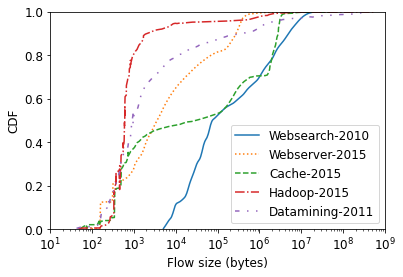

In [34]:
# Figure 13a
raw_trace_dir = os.path.expanduser('../sim/build/traffic_matrix/traces/raw')
cdf_filepaths = sorted(glob.glob(os.path.join(raw_trace_dir, '*.cdf.csv')))

m_label_names = {
    'dctcp.4-websearch' : 'Websearch-2010',
    'sigcomm15-roy-fb.6a-webserver.intra-cluster' : 'Webserver-2015',
    'sigcomm15-roy-fb.6b-cache.intra-cluster' : 'Cache-2015',
    'sigcomm15-roy-fb.6c-hadoop.intra-cluster' : 'Hadoop-2015',
    'vl2.2-datamining' : 'Datamining-2011',
}

index = 0
for cdf_filepath in cdf_filepaths:
    value_cdf_array = []
    f = open(cdf_filepath)
    for line in f:
        if line.startswith('Value'):
            continue
        arr = line.split(',', 2)
        value = float(arr[0])
        percentile = float(arr[1])
        value_cdf_array.append((value, percentile))
    # e.g. '../sim/build/traffic_matrix/traces/raw/sigcomm15-roy-fb.6a-webserver.intra-cluster.cdf.csv'
    (_, cdf_filename) = os.path.split(cdf_filepath)
    r = re.compile(r'(.*)\.cdf\.csv')
    m_trace_name = r.match(cdf_filename)
    trace_name = m_trace_name.group(1) if m_trace_name else cdf_filename
    trace_name = m_label_names[trace_name]
    plot_cdf_tuple_array(value_cdf_array, label=trace_name, index=index)
    index += 1

plt.legend()
plt.xscale('log')
plt.xlim(pow(10, 1), pow(10, 9))
plt.ylim(0, 1)
plt.xlabel('Flow size (bytes)')
plt.ylabel('CDF')

In [35]:
%%script false --no-raise-error

# verify CDF -> PDF  conversion for DCTCP websearch traffic
temp_dir = os.path.expanduser('../sim/build/traffic_matrix/traces/raw')
cdf_filename = 'dctcp.4-websearch.cdf.csv'
value_cdf_array = []
f = open(os.path.join(temp_dir, cdf_filename))
for line in f:
    if line.startswith('Value'):
        continue
    arr = line.split(',', 2)
    value = float(arr[0])
    percentile = float(arr[1])
    value_cdf_array.append((value, percentile))
plot_pdf_from_cdf_tuple_array(value_cdf_array, 'DCTCP.4-websearch', include_count=True)
plt.xscale('log')
plt.xlim(pow(10, 3), pow(10, 8))
plt.ylim(0, 0.12)

In [36]:
%%script false --no-raise-error

# plot original PDF for DCTCP websearch traffic
temp_dir = os.path.expanduser('../sim/build/traffic_matrix/traces/raw')
cdf_filename = 'dctcp.4-websearch.pdf.csv'
value_cdf_array = []
f = open(os.path.join(temp_dir, cdf_filename))
for line in f:
    arr = line.split(',', 2)
    value = float(arr[0])
    percentile = float(arr[1])
    value_cdf_array.append((value, percentile))
plot_cdf_tuple_array(value_cdf_array, 'DCTCP.4-websearch', include_count=True)
plt.xscale('log')
plt.xlim(pow(10, 3), pow(10, 8))
plt.ylim(0, 0.12)

In [46]:
# Part 1: data parsing
# For both figure 13 b/c (vl2.2-datamining and dctcp.4-websearch) and figures in appendix
# Re-run for each trace after changing `base_dir` below, and if only plotting 13 b/c, you can disable all but the last exepriment ('1024h.jellyfish.100G').

# base_dir = os.path.expanduser('../sim/build/sigcomm15-roy-fb.6a-webserver')
# base_dir = os.path.expanduser('../sim/build/sigcomm15-roy-fb.6b-cache')
# base_dir = os.path.expanduser('../sim/build/sigcomm15-roy-fb.6c-hadoop')
# base_dir = os.path.expanduser('../sim/build/vl2.2-datamining')
base_dir = os.path.expanduser('../data/4.traces/dctcp.4-websearch')

experiments = [
    '1024h.fat-tree.10G',
    '1024h.jellyfish.10G',
    '1024h.fat-tree.100G',
    '1024h.jellyfish.100G', # note: only this is needed for figure 13 b/c, the others are for full graphs in appendix.
]
samples_per_flow = 20

all_experiments_data = {}
for experiment in experiments:
    print("Processing experiment %s" % experiment)
    fct_filelist = glob.glob(os.path.join(base_dir, experiment, '*.ssv'))
    if len(fct_filelist) == 0:
        raise ValueError('No FCT files found for %s' % experiment)
    all_experiments_data[experiment] = {}
    for filename in fct_filelist:
        d = parse_fct(filename)
        fct_array = np.array(sorted(get_fct_array_grouped_by_flow(d, samples_per_flow))) * 1e3 # convert to ms
        all_experiments_data[experiment][filename] = fct_array

Processing experiment 1024h.fat-tree.10G
flow count: 4096
min sample count: 1
flow count: 4067
min sample count: 1
flow count: 3790
min sample count: 1
Processing experiment 1024h.jellyfish.10G
flow count: 4081
min sample count: 1
flow count: 4080
min sample count: 1
flow count: 4096
min sample count: 1
flow count: 4019
min sample count: 1
Processing experiment 1024h.fat-tree.100G
flow count: 4096
min sample count: 14
flow count: 4096
min sample count: 5
flow count: 4096
min sample count: 3
Processing experiment 1024h.jellyfish.100G
flow count: 4096
min sample count: 8
flow count: 4096
min sample count: 9
flow count: 4096
min sample count: 22
flow count: 4096
min sample count: 3


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
expriment: 1024h.jellyfish.100G
file: ../data/4.traces/dctcp.4-websearch/1024h.jellyfish.100G/fct.jellyfish.hetero.4x.ssv, fct array length = 32768
file: fct.jellyfish.hetero.4x.ssv, current_network_setup = hetero, label = Parallel heterogeneous, color = #2ca02c
file: ../data/4.traces/dctcp.4-websearch/1024h.jellyfish.100G/fct.jellyfish.homo.4x.ssv, fct array length = 36864
file: fct.jellyfish.homo.4x.ssv, current_network_setup = homo, label = Parallel homogeneous, color = #ff7f0e
file: ../data/4.traces/dctcp.4-websearch/1024h.jellyfish.100G/fct.jellyfish.large.4x.ssv, fct array length = 81920
file: fct.jellyfish.large.4x.ssv, current_network_setup = large, label = Serial high-bw, color = #d62728
file: ../data/4.traces/dctcp.4-websearch/1024h.jellyfish.100G/fct.jellyfish.single.ssv, fct array length = 12288
file: fct.jellyfish.single.ssv, current_network_setup = single, label = Serial low-bw, color = #1f77b4


Text(0, 0.5, 'CDF')

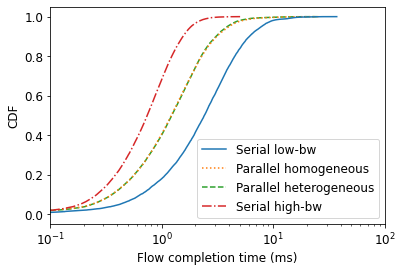

In [52]:
# Part 2: plotting
# Figure 13 b/c only, repeat with previous cell for both traces

fig = plt.figure()
subplot_position = 0
network_setups = ['single', 'large', 'parallel', 'homo', 'hetero']
map_labels = {
    'single': 'Serial low-bw',
    'large': 'Serial high-bw',
    'parallel': 'Parallel homogeneous',
    'homo': 'Parallel homogeneous',
    'hetero': 'Parallel heterogeneous',
}

m_legend_order = {
    'Serial low-bw': 1,
    'Parallel homogeneous': 2,
    'Parallel heterogeneous': 3,
    'Serial high-bw': 4,
}

colors = [get_next_color() for _ in range(4)]
print((colors))
map_colors = {
    'single': colors[0],
    'parallel': colors[1],
    'homo': colors[1],
    'hetero': colors[2],
    'large': colors[3],
}

map_plot_index = {
    'single': 0,
    'parallel': 1,
    'homo': 1,
    'hetero': 2,
    'large': 3,
}

for experiment in all_experiments_data:
    if experiment != '1024h.jellyfish.100G':
        continue
    # subplot_position += 1
    # subplot_hi = plt.subplot(1, 1, subplot_position)
    # subplot_hs.append(subplot_hi)
    print("expriment: %s" % experiment)
    for filepath in all_experiments_data[experiment]:
        fct_array = all_experiments_data[experiment][filepath]
        print("file: %s, fct array length = %d" % (filepath, len(fct_array)))
        (_, filename) = os.path.split(filepath)
        current_network_setup = None
        for network_setup in network_setups:
            if network_setup in filename:
                current_network_setup = network_setup
                break
        if current_network_setup is None:
            raise ValueError('Cannot determine network setup for file %s' % filepath)
        label = map_labels[current_network_setup]
        color = map_colors[current_network_setup]
        print("file: %s, current_network_setup = %s, label = %s, color = %s" % (filename, current_network_setup, label, color))
        plot_cdf_array(fct_array, label=label, color=color, index=map_plot_index[current_network_setup])
    plt.xscale('log')
    # plt.xlim(0.1, 100)
    plt.xlim(0.01, 1)
    # plt.xlim(0.01, 1)
    if '10G' in filepath:
        # plt.xlim(0.01, 10)
        # plt.xlim(0, 1)
        pass
    else:
        if 'datamining' in base_dir:
            plt.xlim(0.01, 1)
        else:
            plt.xlim(0.1, 100)
        # plt.xlim(0, 0.2)
        pass
handles, labels = fig.axes[-1].get_legend_handles_labels()
# print(labels)
legend_order = [m_legend_order[label] for label in labels]
handles = [handle for _, handle in sorted(zip(legend_order, handles))]
labels = [label for _, label in sorted(zip(legend_order, labels))]
# # reorder homogeneous and heterogeneous
# handles[0], handles[1], handles[2], handles[3] = handles[1], handles[0], handles[3], handles[2]
# labels[0], labels[1], labels[2], labels[3] = labels[1], labels[0], labels[3], labels[2]
plt.legend(handles, labels, ncol=1, loc='lower right')
# plt.title('%s Web workload' % experiment)
# plt.xlabel('FCT (ms)')
# plt.ylabel('CDF')

plt.xlabel('Flow completion time (ms)')
plt.ylabel('CDF')

# fig.text(0.5, 0.04, 'Flow completion time (ms)', ha='center')
# fig.text(0.04, 0.5, 'CDF', va='center', rotation='vertical')


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
expriment: 1024h.fat-tree.10G
file: ../data/4.traces/dctcp.4-websearch/1024h.fat-tree.10G/fct.large.4x.ssv, fct array length = 4096
file: fct.large.4x.ssv, current_network_setup = large, label = Serial high-bw, color = #d62728
file: ../data/4.traces/dctcp.4-websearch/1024h.fat-tree.10G/fct.parallel.4x.ssv, fct array length = 4067
file: fct.parallel.4x.ssv, current_network_setup = parallel, label = Parallel homogeneous, color = #ff7f0e
file: ../data/4.traces/dctcp.4-websearch/1024h.fat-tree.10G/fct.single.ssv, fct array length = 3790
file: fct.single.ssv, current_network_setup = single, label = Serial low-bw, color = #1f77b4
expriment: 1024h.jellyfish.10G
file: ../data/4.traces/dctcp.4-websearch/1024h.jellyfish.10G/fct.jellyfish.hetero.4x.ssv, fct array length = 4081
file: fct.jellyfish.hetero.4x.ssv, current_network_setup = hetero, label = Parallel heterogeneous, color = #2ca02c
file: ../data/4.traces/dctcp.4-websearch/1024h.jellyfish.10G/fc

Text(0.04, 0.5, 'CDF')

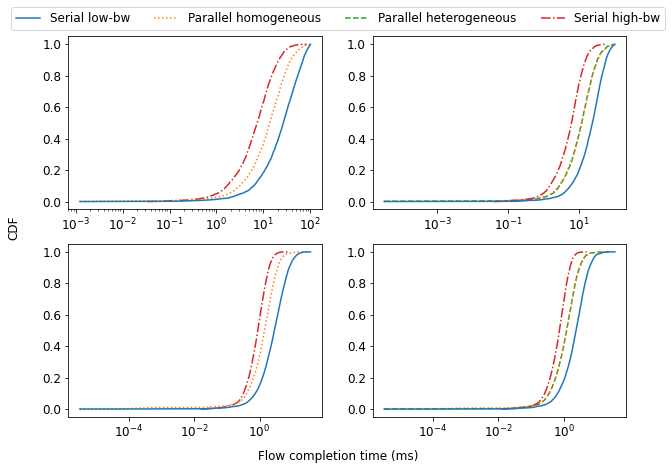

In [51]:
# For figures in appendix only, xlim might need to be adjusted to match the figures in paper.

fig = plt.figure(figsize=(10, 7))
subplot_position = 0
network_setups = ['single', 'large', 'parallel', 'homo', 'hetero']
map_labels = {
    'single': 'Serial low-bw',
    'large': 'Serial high-bw',
    'parallel': 'Parallel homogeneous',
    'homo': 'Parallel homogeneous',
    'hetero': 'Parallel heterogeneous',
}

m_legend_order = {
    'Serial low-bw': 1,
    'Parallel homogeneous': 2,
    'Parallel heterogeneous': 3,
    'Serial high-bw': 4,
}

colors = [get_next_color() for _ in range(4)]
print((colors))
map_colors = {
    'single': colors[0],
    'parallel': colors[1],
    'homo': colors[1],
    'hetero': colors[2],
    'large': colors[3],
}
# linestyles= [get_linestyle(i) for i in range(4)]
# map_linestyles = {
#     'single': linestyles[0],
#     'parallel': linestyles[1],
#     'homo': linestyles[1],
#     'hetero': linestyles[2],
#     'large': linestyles[3],
# }

map_plot_index = {
    'single': 0,
    'parallel': 1,
    'homo': 1,
    'hetero': 2,
    'large': 3,
}

subplot_hs = []
for experiment in all_experiments_data:
    subplot_position += 1
    subplot_hi = plt.subplot(2, 2, subplot_position)
    subplot_hs.append(subplot_hi)
    print("expriment: %s" % experiment)
    for filepath in all_experiments_data[experiment]:
        fct_array = all_experiments_data[experiment][filepath]
        print("file: %s, fct array length = %d" % (filepath, len(fct_array)))
        (_, filename) = os.path.split(filepath)
        current_network_setup = None
        for network_setup in network_setups:
            if network_setup in filename:
                current_network_setup = network_setup
                break
        if current_network_setup is None:
            raise ValueError('Cannot determine network setup for file %s' % filepath)
        label = map_labels[current_network_setup]
        color = map_colors[current_network_setup]
        print("file: %s, current_network_setup = %s, label = %s, color = %s" % (filename, current_network_setup, label, color))
        plot_cdf_array(fct_array, label=label, color=color, index=map_plot_index[current_network_setup])
    plt.xscale('log')
    # plt.xlim(0.1, 100)
    # plt.xlim(0.01, 1)
    # plt.xlim(0.01, 1)
    if '10G' in filepath:
        # plt.xlim(0.01, 10)
        # plt.xlim(0, 1)
        pass
    else:
        # plt.xlim(0.01, 10)
        # plt.xlim(0, 0.2)
        pass
handles, labels = fig.axes[-1].get_legend_handles_labels()
# print(labels)
legend_order = [m_legend_order[label] for label in labels]
handles = [handle for _, handle in sorted(zip(legend_order, handles))]
labels = [label for _, label in sorted(zip(legend_order, labels))]
# # reorder homogeneous and heterogeneous
# handles[0], handles[1], handles[2], handles[3] = handles[1], handles[0], handles[3], handles[2]
# labels[0], labels[1], labels[2], labels[3] = labels[1], labels[0], labels[3], labels[2]
plt.figlegend(handles, labels, ncol=5, loc='upper center', bbox_to_anchor=(0.5, 0.95))
# plt.title('%s Web workload' % experiment)
# plt.xlabel('FCT (ms)')
# plt.ylabel('CDF')

fig.text(0.5, 0.04, 'Flow completion time (ms)', ha='center')
fig.text(0.04, 0.5, 'CDF', va='center', rotation='vertical')